# Set-up

In [1]:
%cd ..

/app


In [4]:
import librosa
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from scipy import stats

from tonami import pitch_process as pp
from tonami import user
from tonami import Utterance as u
from tonami import Classifier as c

In [10]:
# Consts
USER_TESTING_FILEPATH = 'data/user_audio/testing/'
# USER_TESTING_FILEPATH = 'data/native speakers/'
DB_THRESHOLD = 10
user_info = user.User(50, 350)
SAMPLERATE = 22050
clf = c.Classifier(4)
clf.load_clf('tonami/data/pickled_svm_80.pkl')

In [6]:
user_audio_dict = {}
raw_data_dict = {}
times_dict = {}

# Run all tasks (long)

In [7]:
# get all files
filenames = os.listdir(USER_TESTING_FILEPATH)
num_files = len(filenames)

user_audio_dict['Filename'] = filenames

In [8]:
# get target tones
targets = [0] * num_files

for i, filename in enumerate(filenames):
    if i > 2:
        targets[i] = int(filename.split("_")[1][-1])
    else:
        targets[i] = 2

user_audio_dict['Target'] = targets

In [13]:
# load files
time_series_arr = [None] * num_files
load_times = [0] * num_files

for i, filename in enumerate(filenames):
    start = time.time()
    time_series_arr[i], _ = librosa.load(USER_TESTING_FILEPATH + filename)  
    load_times[i] = time.time() - start

raw_data_dict['Time Series'] = time_series_arr
times_dict['load'] = load_times

In [14]:
# get durations
durations = [0] * num_files

for i, time_series in enumerate(time_series_arr):
    durations[i] = len(time_series)/SAMPLERATE

user_audio_dict['Durations'] = durations

In [15]:
# trim files
f_time_series_arr = [None] * num_files
trim_times = [0] * num_files

for i, time_series in enumerate(time_series_arr):
    start = time.time()
    f_time_series_arr[i], _ = librosa.effects.trim(y=time_series, top_db=DB_THRESHOLD) 
    trim_times[i] = time.time() - start

raw_data_dict['Filtered Time Series'] = f_time_series_arr
times_dict['trim'] = trim_times

In [16]:
# get filtered durations
f_durations = [0] * num_files
diff_durations = [0] * num_files

for i, f_time_series in enumerate(f_time_series_arr):
    f_durations[i] = len(f_time_series)/SAMPLERATE
    diff_durations[i] = durations[i]-f_durations[i]

user_audio_dict['Filtered Durations'] = f_durations
user_audio_dict['Diff'] = diff_durations

In [85]:
# get pitch contours
pitch_contour_arr = [None] * num_files
contour_times = [0] * num_files

for i, f_time_series in enumerate(f_time_series_arr):
    start = time.time()
    pitch_contour_arr[i] , _, _ = librosa.pyin(f_time_series, fmin=50, fmax=400)
    contour_times[i] = time.time() - start

raw_data_dict['Pitch Contours'] = pitch_contour_arr
times_dict['contour'] = contour_times

In [86]:
# Tonami's feature extraction   
normalized_pitch_arr = [None] * num_files
nans_arr = [None] * num_files
features_arr = [None] * num_files
extraction_times = [0] * num_files

for i, pitch_contour in enumerate(pitch_contour_arr):
    start = time.time()
    interp, nans_arr[i] = pp.preprocess(pitch_contour)
    interp_np = np.array([interp], dtype=float)
    profile = test_user.get_pitch_profile()
    avgd = pp.moving_average(interp_np)
    normalized_pitch = pp.normalize_pitch(avgd, profile['max_f0'], profile['min_f0'])
    features_arr[i] = np.array([pp.basic_feat_calc(normalized_pitch[0])])
    normalized_pitch_arr[i] = normalized_pitch
    extraction_times[i] = time.time() - start
    
raw_data_dict['Normalized Pitch'] = normalized_pitch_arr
raw_data_dict['Nans'] = nans_arr
raw_data_dict['Features'] = features_arr
times_dict['extraction'] = extraction_times

In [87]:
# Classifier time (svm_80_lda)
class_times = [0] * num_files
classified_tones = [0] * num_files
classified_probs = [None] * num_files
classification_errors = 0;

for i, features in enumerate(features_arr):
    start = time.time()
    try:
        classified_tones[i], classified_probs[i] = clf.classify_tones(features)
    except:
        classification_errors += 1
    class_times[i] = time.time() - start

user_audio_dict['Classified Tones'] = classified_tones
user_audio_dict['Classified Probs'] = classified_probs
times_dict['class'] = class_times

In [88]:
# Get rating
rating_times = [0] * num_files
ratings_arr = [""] * num_files

for i, clf_probs in enumerate(classified_probs):
    start = time.time()
    try:
        target_prob = clf_probs[0][targets[i]-1]

        # if the probability of any other tone is >= 90%, return try again
        for prob in clf_probs[0][np.arange(len(clf_probs[0]))!=(targets[i]-1)]:
            if prob >= 0.9:
                ratings_arr[i] = "Not quite, try again?"

        # if your target probability is more than 50%, you are good
        if target_prob > 0.5:
            ratings_arr[i] = "Great job!"
        else:
            ratings_arr[i] = "Almost there!"
    except:
        ratings_arr[i] = "Unavailable"
    rating_times[i] = time.time() - start

user_audio_dict['Rating'] = ratings_arr
times_dict['rate'] = rating_times

In [11]:
# Processing time (svm_80_lda)    
process_times = [0] * num_files

for i, filename in enumerate(filenames):
    start = time.time()
    user_utterance = u.Utterance(filename=USER_TESTING_FILEPATH + filename)
    _, _, features = user_utterance.pre_process(user_info)
    try:
        _, _ = clf.classify_tones(features)
    except:
        pass
    process_times[i] = time.time() - start

times_dict['total'] = process_times

/opt/conda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1374: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(


In [12]:
# Processing time (svm_80_lda)    2
process_times = [0] * num_files

for i, filename in enumerate(filenames):
    start = time.time()
    user_utterance = u.Utterance(filename=USER_TESTING_FILEPATH + filename, trim=False)
    _, _, features = user_utterance.pre_process(user_info)
    try:
        _, _ = clf.classify_tones(features)
    except:
        pass
    process_times[i] = time.time() - start

times_dict['total (untrimmed)'] = process_times

/opt/conda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1374: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(


# All generated data

In [17]:
# consolidate data
user_audio_df = pd.DataFrame(user_audio_dict)
raw_data_df = pd.DataFrame(raw_data_dict)
times_df = pd.DataFrame(times_dict)

## With Outliers

In [90]:
display(user_audio_df)

,Filename,Target,Classified Tones,Classified Probs,Rating
0,ba1_HV1_ex8_R2_user-testing.mp3,1,[3],"[[8.196817778152959e-08, 3.913516196927801e-08...",Almost there!
1,ba1_LV3_ex8_R4_user-testing.mp3,1,[1],"[[0.9797272123411127, 0.00019016592403607127, ...",Great job!
2,ba1_LV6_ex8_R1_user-testing.mp3,1,[1],"[[0.978796510967838, 0.00012630412554729144, 0...",Great job!
3,bao3_HV4_ex20_R1_user-testing.mp3,3,[1],"[[0.5586142028599321, 0.0018395882327071097, 0...",Almost there!
4,bao3_LV6_ex20_R2_user-testing.mp3,3,[1],"[[0.7085703340140062, 0.028655439369329357, 0....",Almost there!
5,bing1_HV1_ex16_R2_user-testing.mp3,1,[3],"[[9.274350156261208e-08, 1.0277976994934146e-0...",Almost there!
6,bing1_LV2_ex16_R1_user-testing.mp3,1,[1],"[[0.8065271746829039, 0.0073252388991089205, 0...",Great job!
7,bing1_LV6_ex16_R3_user-testing.mp3,1,[1],"[[0.9752824534463194, 0.00021498985120096953, ...",Great job!
8,fa1_HV1_ex3_R1_user-testing.mp3,1,[3],"[[7.375179490201627e-07, 2.958789642290122e-07...",Almost there!
9,fa1_HV4_ex3_R1_user-testing.mp3,1,[3],"[[0.0033807239074884203, 0.0002260959282434348...",Almost there!


In [ ]:
n, bins, _ = plt.hist(user_audio_df['Durations'])
plt.show() 
print(n)
print(bins)

In [ ]:
plt.scatter(user_audio_df['Durations'], times_df['load'])
plt.show()

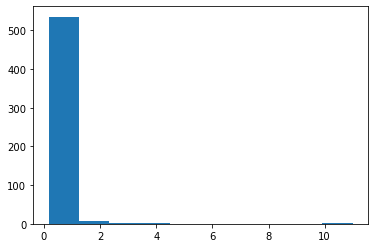

[535.   7.   1.   1.   0.   0.   0.   0.   0.   1.]
[ 0.16253968  1.24691156  2.33128345  3.41565533  4.50002721  5.58439909
  6.66877098  7.75314286  8.83751474  9.92188662 11.0062585 ]


In [13]:
n, bins, _ = plt.hist(user_audio_df['Filtered Durations'])
plt.show() 
print(n)
print(bins)

In [ ]:
plt.scatter(user_audio_df['Filtered Durations'], times_df['contour'])
plt.show()

### Raw Data

In [91]:
display(raw_data_df)

,Time Series,Filtered Time Series,Pitch Contours,Normalized Pitch,Nans,Features
0,"[-2.2323418e-05, -9.556377e-06, -2.1398931e-05...","[0.008356462, 0.0073015993, 0.0058155973, 0.00...","[nan, 284.4812036394563, 273.20805135087915, 2...","[[0.5973124579173754, 0.6031324176103163, 0.63...","[False, False, False, False, False, False, Fal...","[[0.6211809316481113, 0.6401089943865449, 0.59..."
1,"[1.6478629e-07, -1.6929025e-07, 1.6652986e-07,...","[-0.0084268525, -0.006313884, -0.0023718618, -...","[nan, nan, 175.11872228117704, 171.11900513652...","[[1.8264043402083043, 1.849605158062067, 1.902...","[False, False, False, False, False, False, Fal...","[[1.8864387150604478, 2.072237895935814, 2.112..."
2,"[5.593205e-08, -4.320672e-08, 2.5254167e-08, -...","[-0.01579637, -0.0017586777, -0.0072183996, -0...","[nan, 155.11447618337345, 156.0130452026747, 1...","[[2.0820591752473065, 2.0850275605500457, 2.09...","[False, False, False, False, False, False, Fal...","[[2.0944702143850384, 2.142887168565473, 2.179..."
3,"[-4.7085686e-07, 1.6121598e-05, -2.965797e-05,...","[0.16149397, 0.16343096, 0.14990065, 0.1235436...","[nan, nan, nan, 209.4588245641254, 205.8604473...","[[1.3632580340046587, 1.4034857262998215, 1.47...","[False, False, False, False, False, False, Fal...","[[1.6930268250007348, 1.7961841709867103, 1.53..."
4,"[1.4438017e-07, -1.4551632e-07, 1.4012384e-07,...","[-0.02786146, -0.022654438, -0.017134013, -0.0...","[nan, nan, nan, 137.3953647458089, 136.6040256...","[[2.414505507612472, 2.417463601377066, 2.4234...","[False, False, False, False, False, False, Fal...","[[2.43484434936543, 2.7837483289567047, 3.0589..."
5,"[1.7059865e-05, 8.577302e-06, 3.66678e-08, -1....","[0.0173583, 0.03505041, 0.06005359, 0.05949120...","[nan, nan, 301.3973362949152, 294.513411620105...","[[0.4283660086986604, 0.4012486703494046, 0.25...","[False, False, False, False, False, True, True...","[[0.26029893582468155, 0.11943758057184553, 0...."
6,"[9.263582e-06, 8.813827e-06, -3.856561e-06, 3....","[-0.013737056, -0.016202377, -0.0030810894, 0....","[nan, 231.07053937445463, 221.91389441356898, ...","[[1.137409639999217, 1.1660393610793256, 1.224...","[False, False, False, False, False, False, Fal...","[[1.3792184084250534, 1.893715138482539, 2.003..."
7,"[5.3673226e-08, -6.89991e-08, 8.60138e-08, -1....","[2.0850384e-06, -2.4053743e-05, -3.3571647e-05...","[nan, nan, 176.1331747192297, 173.107312201228...","[[1.7969425659891067, 1.8115453095712417, 1.84...","[False, False, False, False, False, False, Fal...","[[1.8174862400751006, 1.9085615762361499, 1.95..."
8,"[-9.860878e-06, 1.4507506e-05, 1.2650449e-05, ...","[0.001696023, -0.0022924992, 0.001871909, -0.0...","[nan, nan, 263.9015821545788, 263.901582154578...","[[0.7225384951092451, 0.7165811056383319, 0.71...","[False, False, False, False, False, False, Fal...","[[0.728784170261815, 0.7685447406661127, 0.753..."
9,"[-3.186856e-05, 1.1959399e-05, -1.5235764e-05,...","[-0.017877454, -0.019538423, -0.037981894, -0....","[nan, 231.07053937445463, 232.40911739156792, ...","[[1.0579635123117417, 1.0549813863807513, 1.04...","[False, False, False, False, False, False, Fal...","[[1.0472663200422034, 1.00568755303741, 0.9724..."


### Times

In [ ]:
display(times_df)

## Without Outliers

In [18]:
outliers = user_audio_df[user_audio_df['Filtered Durations'] > 0.8].index
print("Num of outliers: ", len(outliers))
user_audio_df_fix = user_audio_df.drop(outliers)
raw_data_df_fix = raw_data_df.drop(outliers)
times_df_fix = times_df.drop(outliers)

Num of outliers:  1


### User Audio

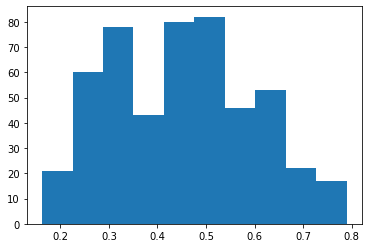

[21. 60. 78. 43. 80. 82. 46. 53. 22. 17.]
[0.16253968 0.22523356 0.28792744 0.35062132 0.41331519 0.47600907
 0.53870295 0.60139683 0.6640907  0.72678458 0.78947846]


In [20]:
n, bins, _ = plt.hist(user_audio_df_fix['Filtered Durations'])
plt.show() 
print(n)
print(bins)

# Report

In [12]:
# File report
print("Audio File Statistics")
print("Quantity :", user_audio_df.shape[0])
print("Duration :", "%.2f" % round(user_audio_df['Durations'].mean(), 2), u"\u00B1", "%.2f" % round(user_audio_df['Durations'].std(), 2) )
print("Filtered :", "%.2f" % round(user_audio_df['Filtered Durations'].mean(), 2), u"\u00B1", "%.2f" % round(user_audio_df['Filtered Durations'].std(), 2) )
print("Difference :", "%.2f" % round(user_audio_df['Diff'].mean(), 2), u"\u00B1", "%.2f" % round(user_audio_df['Diff'].std(), 2) )
print("\n")

print("Audio File Statistics (w/o outliers)")
print("Quantity :", user_audio_df_fix.shape[0])
print("Duration :", "%.2f" % round(user_audio_df_fix['Durations'].mean(), 2), u"\u00B1", "%.2f" % round(user_audio_df_fix['Durations'].std(), 2) )
print("Filtered :", "%.2f" % round(user_audio_df_fix['Filtered Durations'].mean(), 2), u"\u00B1", "%.2f" % round(user_audio_df_fix['Filtered Durations'].std(), 2) )
print("Difference :", "%.2f" % round(user_audio_df_fix['Diff'].mean(), 2), u"\u00B1", "%.2f" % round(user_audio_df_fix['Diff'].std(), 2) )

Audio File Statistics
Quantity : 545
Duration : 2.75 ± 1.03
Filtered : 0.53 ± 0.54
Difference : 2.22 ± 0.92


Audio File Statistics (w/o outliers)
Quantity : 502
Duration : 2.69 ± 0.89
Filtered : 0.45 ± 0.14
Difference : 2.24 ± 0.89


In [ ]:
# Time breakdown reports
print("Task Time Statistics (microseconds)")
for name, values in times_df.items():
    print("%10s :" % name, 
          "%6i" % (values.mean()*1000000), 
          u"\u00B1", 
          "%6i" % (values.std()*1000000)
         )    
print("\n")

print("Task Time Statistics (w/o outliers) (microseconds)")
for name, values in times_df_fix.items():
    print("%10s :" % name, 
          "%6i" % (values.mean()*1000000),
          u"\u00B1", 
          "%6i" % (values.std()*1000000)
         )

In [38]:
print("Classification errors: ", classification_errors)

Classification errors:  64


In [21]:
t, p = stats.ttest_rel(times_df_fix['total'], times_df_fix['total (untrimmed)'])
print("t-statistic: ", t)
print("p-value: ", p)

t-statistic:  0.9225521185030654
p-value:  0.3684421592120307
